<a href="https://colab.research.google.com/github/pajonnakuti/pyDataviz/blob/main/WindVectors_Quiver_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 67.8 MB/s eta 0:00:00


In [77]:
# -*- coding: utf-8 -*-
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
from windrose import WindroseAxes

In [78]:
# === Load NetCDF file ===
# Example: a dataset with u (zonal) and v (meridional) components
ds = xr.open_dataset("/content/drive/MyDrive/PyDataViz/2020.nc")
print(ds)


<xarray.Dataset> Size: 4GB
Dimensions:    (time: 8784, latitude: 101, longitude: 101)
Coordinates:
  * latitude   (latitude) float32 404B 25.0 24.75 24.5 24.25 ... 0.5 0.25 0.0
  * longitude  (longitude) float32 404B 75.0 75.25 75.5 ... 99.5 99.75 100.0
  * time       (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    msl        (time, latitude, longitude) float64 717MB ...
    sp         (time, latitude, longitude) float64 717MB ...
    sst        (time, latitude, longitude) float64 717MB ...
    t2m        (time, latitude, longitude) float64 717MB ...
    u10        (time, latitude, longitude) float64 717MB ...
    v10        (time, latitude, longitude) float64 717MB ...
Attributes:
    Conventions:  CF-1.6
    history:      Thu Jul  8 14:53:08 2021: ncks -O -d time,8760,17543 era5_2...
    NCO:          "4.5.4"


In [79]:
# Replace with actual variable names from your file
lon = ds['longitude'].values
lat = ds['latitude'].values
u = ds['u10'].isel(time=0).values   # take first time slice
v = ds['v10'].isel(time=0).values

In [80]:
# === Create a meshgrid for quiver ===
Lon, Lat = np.meshgrid(lon, lat)

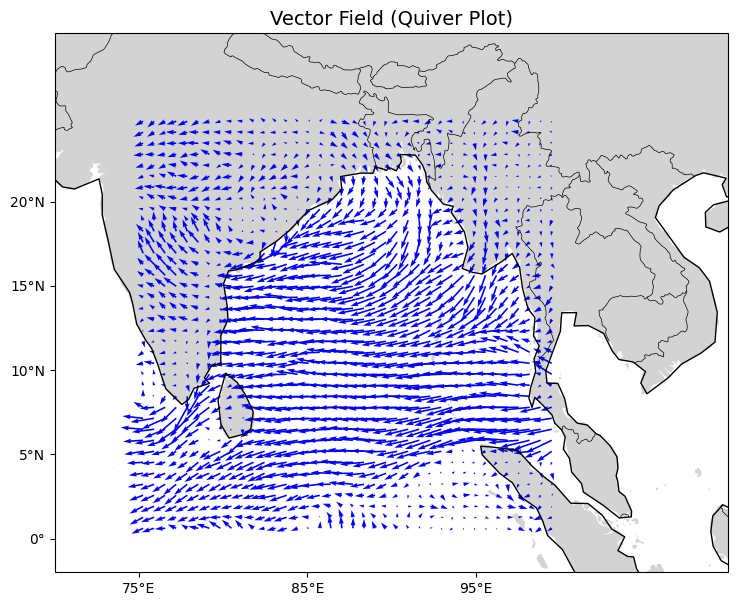

In [82]:
# === Create plot ===
plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set limits (lon_min, lon_max, lat_min, lat_max)
ax.set_extent([70, 110, -2, 30], crs=ccrs.PlateCarree())

# Add base map
ax.coastlines(resolution="110m")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgray")


# Subsample arrows to avoid clutter
skip = (slice(None, None, 5), slice(None, None, 5))

#qv = ax.quiver(Lon[skip], Lat[skip], u[skip], v[skip],
qv = ax.quiver(Lon, Lat, u, v,
               transform=ccrs.PlateCarree(),
               scale=200, regrid_shape=50, color="blue")
# add lat/lon ticks
ax.set_xticks(np.arange(np.floor(lon.min()), np.ceil(lon.max()), 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(np.floor(lat.min()), np.ceil(lat.max()), 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f', degree_symbol='°')
lat_formatter = LatitudeFormatter(number_format='.0f', degree_symbol='°')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.title("Vector Field (Quiver Plot)", fontsize=14)
plt.show()


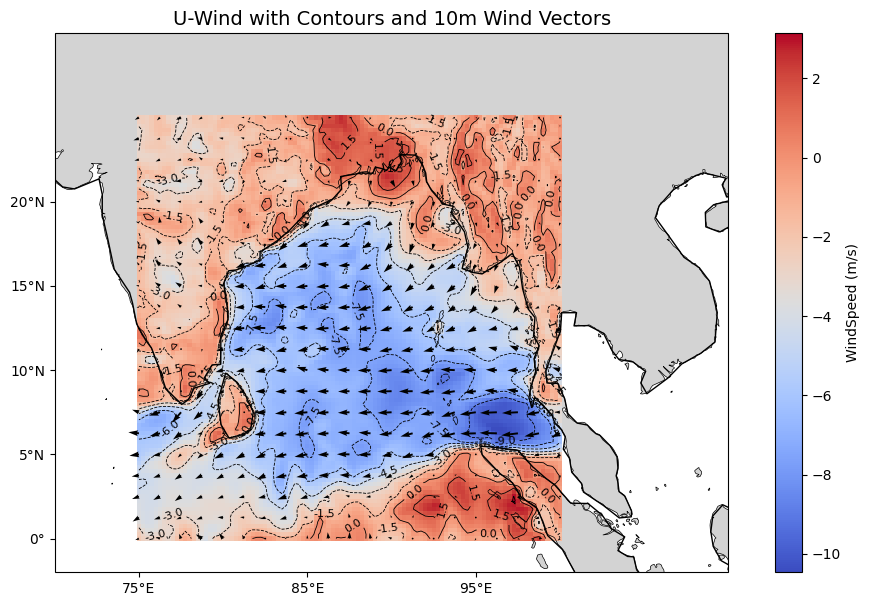

In [83]:

# === Create figure ===
plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (lon_min, lon_max, lat_min, lat_max)
ax.set_extent([70, 110, -2, 30], crs=ccrs.PlateCarree())

# Add base map
ax.coastlines(resolution="110m")
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgray")

# === Pcolor plot (SST background) ===
pcm = ax.pcolormesh(Lon, Lat, u, cmap="coolwarm", shading="auto",
                    transform=ccrs.PlateCarree())
plt.colorbar(pcm, ax=ax, orientation="vertical", label="WindSpeed (m/s)")

# === Contours on top of pcolor ===
cs = ax.contour(Lon, Lat, u, levels=10, colors="k",
                linewidths=0.6, transform=ccrs.PlateCarree())
ax.clabel(cs, inline=True, fontsize=8, fmt="%.1f")

# === Quiver plot (winds) ===
skip = (slice(None, None, 5), slice(None, None, 5))  # subsample for clarity
qv = ax.quiver(Lon[skip], Lat[skip], u[skip], v[skip],
               transform=ccrs.PlateCarree(), scale=400, color="black")

# add lat/lon ticks
ax.set_xticks(np.arange(np.floor(lon.min()), np.ceil(lon.max()), 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(np.floor(lat.min()), np.ceil(lat.max()), 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f', degree_symbol='°')
lat_formatter = LatitudeFormatter(number_format='.0f', degree_symbol='°')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.title("U-Wind with Contours and 10m Wind Vectors", fontsize=14)
plt.show()


In [29]:
# === Build ocean mask (land = NaN) ===
land_geom = list(cfeature.NaturalEarthFeature(
    "physical", "land", "110m").geometries())

In [31]:
mask = np.ones_like(u, dtype=bool)  # True = ocean, False = land
for i in range(Lat.shape[0]):
    for j in range(Lat.shape[1]):
        pt = Point(Lon[i, j], Lat[i, j])
        if any(poly.contains(pt) for poly in land_geom):
            mask[i, j] = False  # mark as land


In [32]:
# Apply mask (set land to NaN)
u_masked = np.where(mask, u, np.nan)
v_masked = np.where(mask, v, np.nan)

In [44]:
wind_speed = np.sqrt(u_masked**2 + v_masked**2)

# === Compute statistics ===
wind_stats = {
    "Mean": np.nanmean(wind_speed),
    "Std": np.nanstd(wind_speed),
    "Min": np.nanmin(wind_speed),
    "Max": np.nanmax(wind_speed)
}

print("Wind Speed Stats:", wind_stats)

Wind Speed Stats: {'Mean': np.float64(5.3058443570506375), 'Std': np.float64(2.2182016157724718), 'Min': np.float64(0.021570466990172264), 'Max': np.float64(10.48707315129864)}


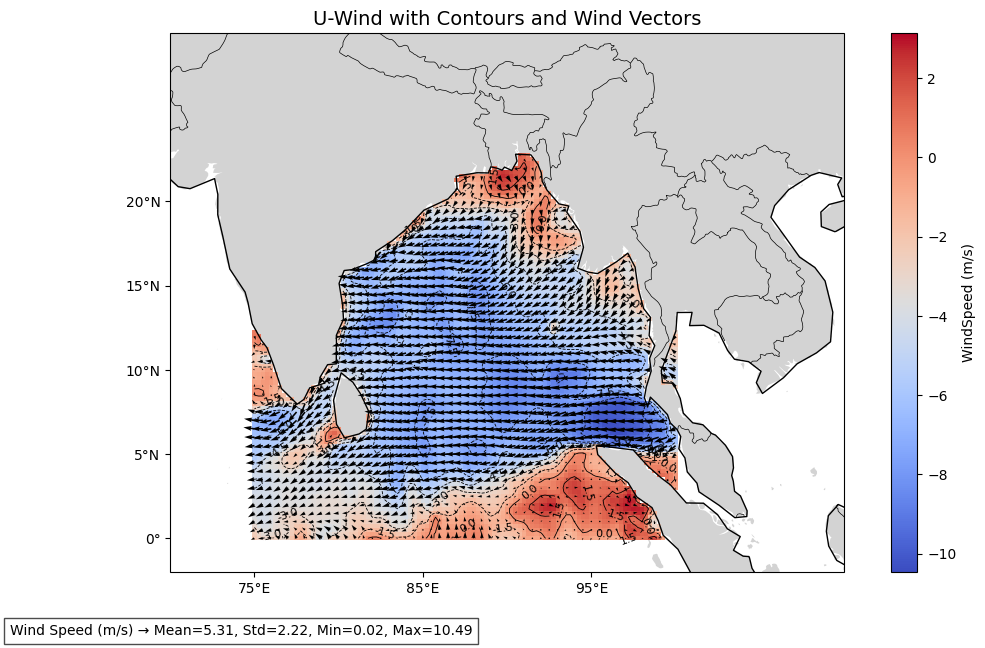

In [74]:
# === Plot ===
plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([70, 110, -2, 30], crs=ccrs.PlateCarree())

# Base map
ax.coastlines(resolution="110m")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgray")

# Pcolor SST (masked)
pcm = ax.pcolormesh(Lon, Lat, u_masked, cmap="coolwarm", shading="auto",
                    transform=ccrs.PlateCarree())
plt.colorbar(pcm, ax=ax, label="WindSpeed (m/s)")

# Contours
cs = ax.contour(Lon, Lat, u_masked, levels=10, colors="k",
                linewidths=0.6, transform=ccrs.PlateCarree())
ax.clabel(cs, inline=True, fontsize=8, fmt="%.1f")

# Quiver winds (masked)
skip = (slice(None, None, 2), slice(None, None, 2))
ax.quiver(Lon[skip], Lat[skip], u_masked[skip], v_masked[skip],
          transform=ccrs.PlateCarree(), scale=400, color="black")

# === Annotate statistics on plot ===
textstr = (f"Wind Speed (m/s) → Mean={wind_stats['Mean']:.2f}, Std={wind_stats['Std']:.2f}, "
           f"Min={wind_stats['Min']:.2f}, Max={wind_stats['Max']:.2f}")

plt.gcf().text(0.05, 0.02, textstr, fontsize=10, bbox=dict(facecolor="white", alpha=0.7))

# add lat/lon ticks
ax.set_xticks(np.arange(np.floor(lon.min()), np.ceil(lon.max()), 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(np.floor(lat.min()), np.ceil(lat.max()), 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f', degree_symbol='°')
lat_formatter = LatitudeFormatter(number_format='.0f', degree_symbol='°')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.title("U-Wind with Contours and Wind Vectors", fontsize=14)
plt.show()


In [49]:
!pip install windrose

Selected grid: lon=82.00, lat=15.00


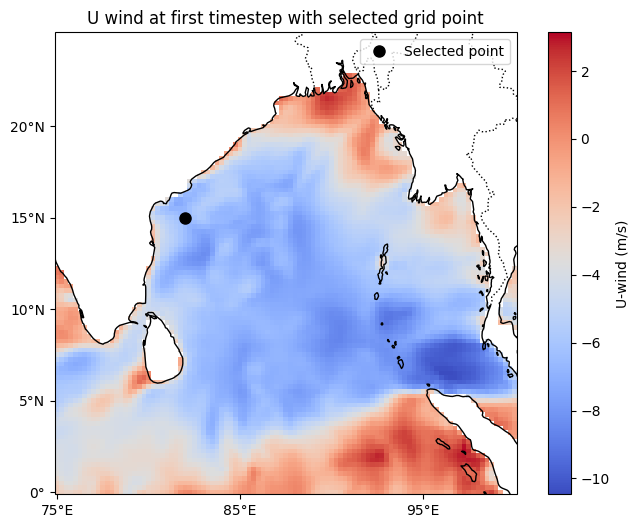

In [72]:
# ==== 2. Select grid point ====
# Example: point near (80E, 15N)
target_lon, target_lat = 82, 15
ilon = np.abs(lon - target_lon).argmin()
ilat = np.abs(lat - target_lat).argmin()

print(f"Selected grid: lon={lon[ilon]:.2f}, lat={lat[ilat]:.2f}")

# ==== 3. Plot pcolor of U ====
plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
p = ax.pcolormesh(lon, lat, u_masked, cmap='coolwarm', transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
plt.colorbar(p, label="U-wind (m/s)")
ax.plot(lon[ilon], lat[ilat], 'ko', markersize=8, label="Selected point")
ax.legend()

# add lat/lon ticks
ax.set_xticks(np.arange(np.floor(lon.min()), np.ceil(lon.max()), 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(np.floor(lat.min()), np.ceil(lat.max()), 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f', degree_symbol='°')
lat_formatter = LatitudeFormatter(number_format='.0f', degree_symbol='°')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.title("U wind at first timestep with selected grid point")
plt.show()

In [69]:
# Choose a grid point (example: 15°N, 80°E)
lat_sel = 15.0
lon_sel = 82.0

# Extract time series at the selected location
u_ts = ds['u10'].sel(latitude=lat_sel, longitude=lon_sel, method="nearest").values
v_ts = ds['v10'].sel(latitude=lat_sel, longitude=lon_sel, method="nearest").values


<Figure size 800x800 with 0 Axes>

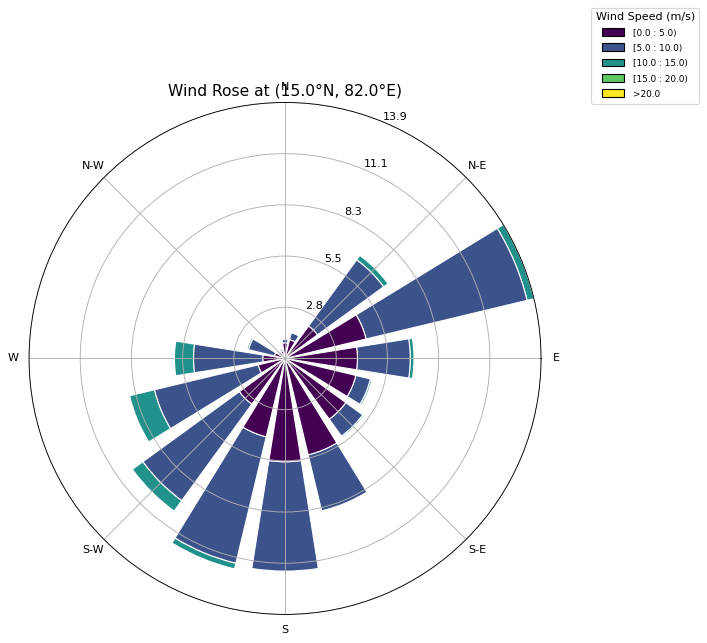

In [70]:
# === Compute wind speed & direction ===
wind_speed = np.sqrt(u_ts**2 + v_ts**2)

# Meteorological convention: 0° = from North, 90° = from East
wind_dir = (np.degrees(np.arctan2(-u_ts, -v_ts)) + 360) % 360

# === Plot wind rose ===
from windrose import WindroseAxes # Import WindroseAxes

plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax()
ax.bar(wind_dir, wind_speed, bins=np.arange(0, 25, 5),  # speed bins [0-5, 5-10, ...]
       normed=True, opening=0.8, edgecolor="white")

# Legend & title
ax.set_legend(title="Wind Speed (m/s)", bbox_to_anchor=(1.1, 1))
plt.title(f"Wind Rose at ({lat_sel}°N, {lon_sel}°E)", fontsize=14)
plt.show()